## Логистическая регрессия

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

Реализуйте обучение логистической регрессии с $L^1$ и $L^2$ регуляризацией с помощью метода Stochastic Gradient Descent (SGD)

#### Замечания
* В SGD градиент расчитывается по одному случайному объекту
* Для отладки работы алгоритма, реализуйте возможность сохранения или вывода ошибки модели после очередной итерации
* Правило останова - максимальное количество эпох
    
Эпохой в SGD и MB-SGD называется один проход по **всем** объектам в выборке (тем или иным способом)

# Реализация модели

In [115]:
from sklearn.base import BaseEstimator, ClassifierMixin
           
def sigmoid(x):
    return 1/(1 + np.exp(-x))

class MySGDClassifier(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """

    def __init__(self, C=1, alpha=0.01, max_epoch=100, penalty='l2'):
        """
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        """

        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.penalty = penalty
        self.cost = []
        self.theta = 1

    def compute_cost(self, theta, X, y=None):
        predict = 0
        for i in range(0, len(y)):
            predict = predict + -y[i] * np.log(sigmoid(theta.T @ X[i].T)) - (1 - y[i]) * np.log(
                1 - sigmoid(theta.T @ X[i].T))

        if self.penalty == 'l2':
            return predict / len(y) + self.alpha * np.sum(theta ** 2) / (2 * len(y))
        elif self.penalty == 'l1':
            return predict / len(y) + self.alpha * np.sum(np.abs(theta)) / (2 * len(y))

    def regulirize(self, w):
        if self.penalty == 'l2':
            w[0] = 0
            return self.C * w
        elif self.penalty == 'l1':
            return self.C * np.sign(w)

    def fit(self, X, y=None):
        # Добавляем колонку для дальнейшего определения w0
        X1 = np.insert(X, 0, [1], 1)

        # Инициализируем начальные веса случайными значаниями в диапазоне low=-1/len(X1[0]), high=1/len(X1[0])
        th = np.random.uniform(low=-1/len(X1[0]), high=1/len(X1[0]), size=(len(X1[0]), 1))        
        
        alpha = self.alpha
        counter = 1
        
        np.random.seed(0)
        
        for epoch in range(0, self.max_epoch):
            # Получаем случайную последоваетльность обучающей выборки
            index = np.random.permutation(len(X1))
            for i in index:
                # Расчитываем градиент по одному элементу выборки
                grad = ((sigmoid(th.T @ X1[i].T) - y[i]) * X1[i].T)
                
                # Получаем новые веса, учитывая регуляризацию
                th = th.T - alpha * (grad + self.regulirize(th.T))
                th = th.T
                
                # Уменьшаем коэффициент alpha для улучшения сходимости
                alpha = self.alpha / counter
                counter += 1
            
            # Расчитываем функцию стоимости
            self.cost.append(self.compute_cost(th, X1, y))

        self.theta = th
        return self

    def partial_fit(self, X, y=None):
        return self

    def predict(self, X):        
        y_hat = np.zeros(len(X))
        for i in range(0, len(X)):
            y_hat[i] = 1 if sigmoid(self.theta.T @ X[i].T) > 0.5 else 0

        return y_hat

    def predict_proba(self, X):
        y_hat_proba = np.zeros(len(X))
        for i in range(0, len(X)):
            y_hat_proba[i] = sigmoid(self.theta.T @ X[i].T)

        return y_hat_proba

    def get_weight(self):
        return self.theta

    def get_cost(self):
        return self.cost

## Проверка на синтетических данных (2 балл)

Запустите ваш алгоритм на синтетических данных. 
Выведите полученные веса и нарисуйте разделяющую границу между классами.

array([1.71164662])

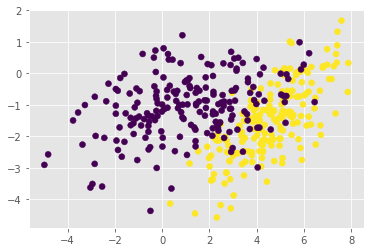

In [69]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

plt.scatter(X[:,0], X[:,1], c=y)

X1 = np.insert(X, 0, [1], 1)

# Инициализируем начальные веса случайными значаниями в диапазоне low=-1/len(X1[0]), high=1/len(X1[0])
th = np.random.uniform(low=-1/len(X1[0]), high=1/len(X1[0]), size=(len(X1[0]), 1))   


In [120]:
model = MySGDClassifier(1, 0.01, 10, 'l2')
model.fit(X, y)

MySGDClassifier(C=1, alpha=0.01, max_epoch=10, penalty='l2')

array([[-0.00509172],
       [-0.0060672 ],
       [ 0.00236708]])

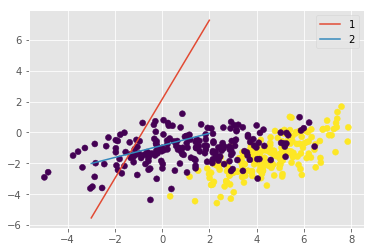

In [121]:
## Your Code Here
weights = model.get_weight()

x = []
z = []
z2 = []

for i in range(-3, 3):
    x.append(i)
    z.append(-(weights[1]/weights[2])*i - weights[0]/weights[2])
    z2.append(-(weights[2]/weights[1])*i - weights[0]/weights[1])

fig, ax = plt.subplots()
ax.scatter(X[:,0], X[:,1], c=y)
ax.plot(x, z, label='1')
ax.plot(x, z2, label='2')
ax.legend()
weights


## Анализ сходимости

Покажите сходимость вашего метода: изобразите графики зависимости значения функции потерь (по всей выборке) после очередной итерации/эпохи (выбрать одно) для разных `alpha`.

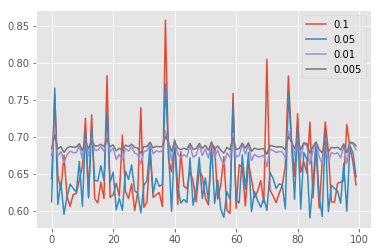

In [16]:
## Your Code Here

fig, ax = plt.subplots()

alphas = [0.1, 0.05, 0.01, 0.005]

for alpha in alphas:
    model1 = MySGDClassifier(0.1, alpha, 100)
    model1.fit(X, y)
    ax.plot(model1.get_cost(), label=alpha)
ax.legend()